<a href="https://colab.research.google.com/github/tiffanyformosa/kdg/blob/forward_transfer/docs/tutorials/kdf_notebooks/KDF_ProgSpiral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install libraries

!rm -r kdg
!git clone --branch forward_transfer https://github.com/tiffanyformosa/kdg
!ls
!pip install kdg/.

rm: cannot remove 'kdg': No such file or directory
Cloning into 'kdg'...
remote: Enumerating objects: 6785, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 6785 (delta 72), reused 95 (delta 58), pack-reused 6672
Receiving objects: 100% (6785/6785), 170.41 MiB | 13.54 MiB/s, done.
Resolving deltas: 100% (2670/2670), done.
Checking out files: 100% (525/525), done.
kdg  sample_data
Processing ./kdg
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 462 kB 15.3 MB/s 
  Created wheel for kdg: filename=kdg-0.0.1-py3-none-any.whl size=17852 sha256

In [ ]:
# import modules
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

from joblib import Parallel, delayed

from kdg.kdf import *
from kdg.utils import *

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Spiral Test

In [ ]:
def get_posteriors(network, label):
    #define grids
    p = np.arange(-3, 3, step=0.01)
    q = np.arange(-3, 3, step=0.01)
    xx, yy = np.meshgrid(p, -q)
    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
    posteriors = network.predict_proba(grid_samples, label)
    posteriors = posteriors[:,0].reshape(600,600)

    return(posteriors)

# RF params
fit_kwargs = {"n_estimators": 500, "verbose": 0}

Spiral5 accuracy: 0.9092


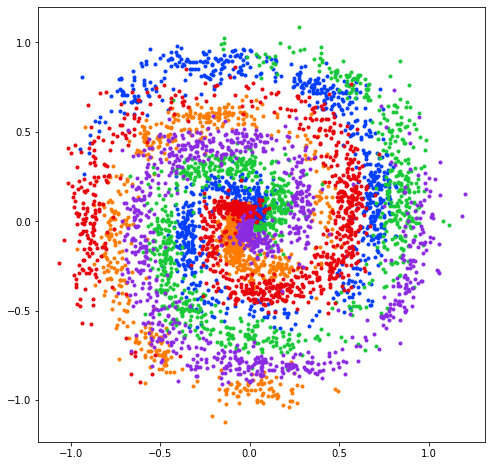

In [ ]:
n_labels = 5
task_id = f"Spiral{n_labels}"
X1, y1 = generate_spirals(2000, n_class=n_labels)
X1_test, y1_test = generate_spirals(5000, n_class=n_labels)

kdf_spiral = kdf(kwargs = fit_kwargs)
kdf_spiral.fit(X1, y1, task_id, **fit_kwargs)
acc = np.mean(kdf_spiral.predict(X1_test, task_id) == y1_test)

Xgen, ygen = kdf_spiral.generate_data(5000, task_id)
print(f"{task_id} accuracy: {acc}")
plot_2dsim(Xgen, ygen, palette="bright")

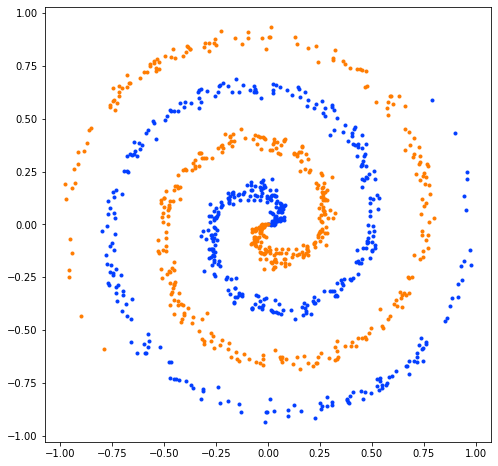

In [ ]:
plot_2dsim(X1, y1, palette="bright")

### Posteriors

In [ ]:
n_train = 1000
n_test = 1000

X1, y1 = generate_spirals(n_train, n_class=2)
X1_test, y1_test = generate_spirals(n_test, n_class=2)

X2, y2 = generate_spirals(n_train, n_class=2)
y2 = -1*(y2 - 1)
X2_test, y2_test = generate_spirals(n_test, n_class=2)
y2_test = -1*(y2_test - 1)

label1 = "Spiral2"
label2 = "SpiralFlip"

kdf_2task = kdf(kwargs = fit_kwargs)
kdf_2task.fit(X1, y1, label1, **fit_kwargs)
kdf_2task.fit(X2, y2, label2, **fit_kwargs)

print(f"Posterior sizes {label1}: {np.sum(np.nan_to_num(kdf_2task.polytope_sizes[label1]), axis=0)}")
print(f"Posterior sizes {label2}: {np.sum(np.nan_to_num(kdf_2task.polytope_sizes[label2]), axis=0)}")

kdf_2task.forward_transfer(X1, y1, label1)
kdf_2task.forward_transfer(X2, y2, label2)

print(f"Posterior sizes {label1}: {np.sum(np.nan_to_num(kdf_2task.polytope_sizes[label1]), axis=0)}")
print(f"Posterior sizes {label2}: {np.sum(np.nan_to_num(kdf_2task.polytope_sizes[label2]), axis=0)}")

Posterior sizes Spiral2: [119491. 123307.]
Posterior sizes SpiralFlip: [122033. 116262.]
Posterior sizes Spiral2: [119991. 123807.]
Posterior sizes SpiralFlip: [122533. 116762.]


In [ ]:
n_trees = np.arange(100, 501, step=100).astype(int)
n_samples = np.arange(100, 1001, step=100).astype(int)
reps = 5
sample_size = []
posterior_size = []
forest_size = []

for t in n_trees:
    fit_kwargs = {"n_estimators": t, "verbose": 0}
    print(f"Testing {t} trees")
    for n in n_samples:
        for r in range(reps):
            X1, y1 = generate_spirals(n, n_class=2)
            kdf_test = kdf(kwargs = fit_kwargs)
            kdf_test.fit(X1, y1, "test", **fit_kwargs)
            p = np.sum(np.nan_to_num(kdf_test.polytope_sizes["test"]), axis=0)
            posterior_size = posterior_size + p.tolist()
            sample_size = sample_size + [np.sum(y1==0), np.sum(y1==1)]
            forest_size = forest_size + [t, t]

Testing 100 trees
Testing 200 trees
Testing 300 trees
Testing 400 trees
Testing 500 trees


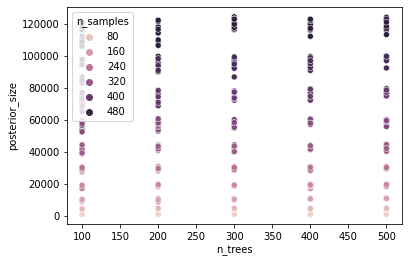

In [ ]:
df = pd.DataFrame({"n_samples": sample_size,
                   "n_trees": forest_size,
                   "posterior_size": posterior_size,
                   }
                  )
sns.scatterplot(x='n_trees', y='posterior_size', hue='n_samples', data=df) 

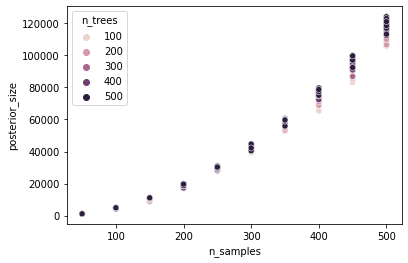

In [ ]:
sns.scatterplot(x='n_samples', y="posterior_size", hue='n_trees', data=df) 

In [ ]:
#goes in increments of 100
for i in range(5):
    print(np.polyfit(sample_size[100*i:100*(i+1)],
                     posterior_size[100*i:100*(i+1)],
                     3))

[ 1.72907537e-05  4.17354825e-01  1.23605750e+01 -6.80586667e+02]
[-8.69807304e-05  5.18343497e-01 -6.43722183e+00  1.97603333e+02]
[ 1.57100233e-04  3.55785944e-01  2.39569709e+01 -1.11929667e+03]
[-6.34921523e-05  5.17970723e-01 -6.97503652e+00  2.72160000e+02]
[-5.94571873e-05  5.21325664e-01 -7.14395260e+00  3.32266667e+02]


In [ ]:
np.unique(y1)

array([0, 1])

## Visualize Posteriors

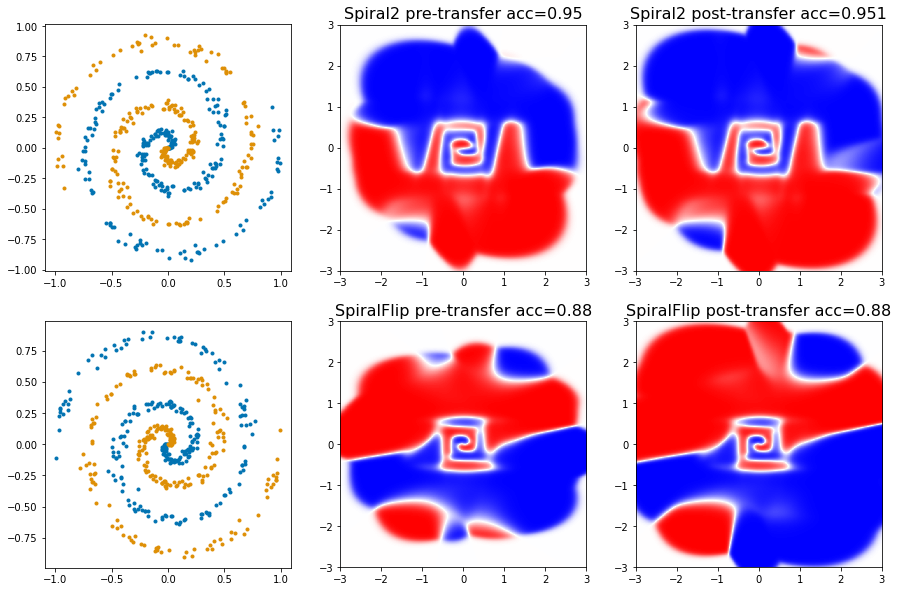

In [ ]:
n_train = 500
n_test = 1000

X1, y1 = generate_spirals(n_train, n_class=2)
X1_test, y1_test = generate_spirals(n_test, n_class=2)

X2, y2 = generate_spirals(n_train, n_class=2)
y2 = -1*(y2 - 1)
X2_test, y2_test = generate_spirals(n_test, n_class=2)
y2_test = -1*(y2_test - 1)

label1 = "Spiral2"
label2 = "SpiralFlip"

kdf_2task = kdf(kwargs = fit_kwargs)
kdf_2task.fit(X1, y1, label1, **fit_kwargs)
kdf_2task.fit(X2, y2, label2, **fit_kwargs)
post1 = get_posteriors(kdf_2task, label1)
post2 = get_posteriors(kdf_2task, label2)
t1_acc = np.mean(kdf_2task.predict(X1_test, label1) == y1_test)
t2_acc = np.mean(kdf_2task.predict(X2_test, label2) == y2_test)

fig1, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0,0] = plot_2dsim(X1, y1, ax=ax[0,0])
ax[1,0] = plot_2dsim(X2, y2, ax=ax[1,0])

ax[0, 1].imshow(
    post1,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0, 1].set_title(f"{label1} pre-transfer acc={t1_acc}", fontsize=16)
ax[0, 1].set_aspect("equal")

ax[1, 1].imshow(
    post2,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1, 1].set_title(f"{label2} pre-transfer acc={t2_acc}", fontsize=16)
ax[1, 1].set_aspect("equal")

X1_trans, y1_trans = kdf_2task.generate_data(n_train, label1)
X2_trans, y2_trans = kdf_2task.generate_data(n_train, label2)
kdf_2task.forward_transfer(X1_trans, y1_trans, label1)
kdf_2task.forward_transfer(X2_trans, y2_trans, label2)

post1_trans = get_posteriors(kdf_2task, label1)
post2_trans = get_posteriors(kdf_2task, label2)
t1_acc_trans = np.mean(kdf_2task.predict(X1_test, label1) == y1_test)
t2_acc_trans = np.mean(kdf_2task.predict(X2_test, label2) == y2_test)

ax[0, 2].imshow(
    post1_trans,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0, 2].set_title(f"{label1} post-transfer acc={t1_acc_trans}", fontsize=16)
ax[0, 2].set_aspect("equal")

ax[1, 2].imshow(
    post2_trans,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1, 2].set_title(f"{label2} post-transfer acc={t2_acc_trans}", fontsize=16)
ax[1, 2].set_aspect("equal")

### Posterior With Reused Data

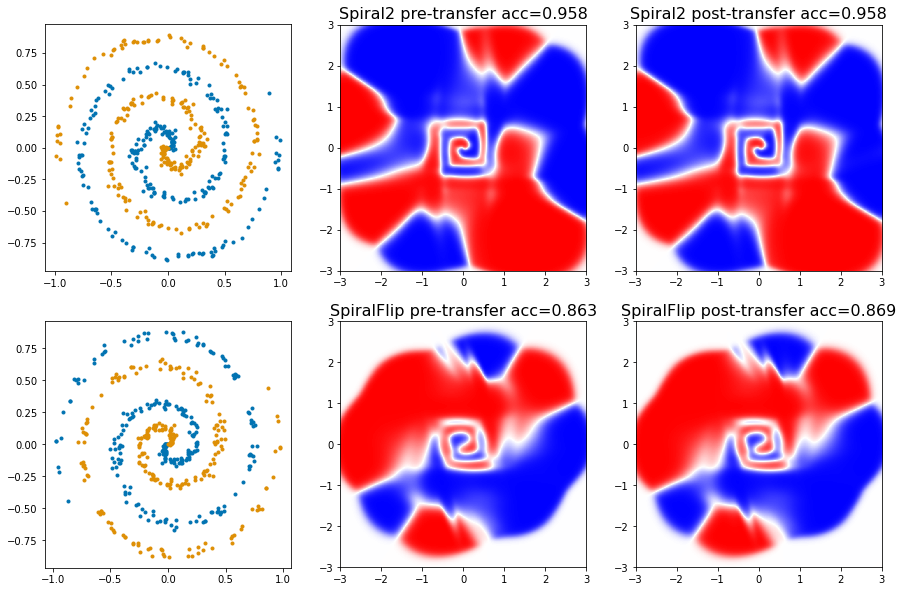

In [ ]:
n_train = 500
n_test = 1000

X1, y1 = generate_spirals(n_train, n_class=2)
X1_test, y1_test = generate_spirals(n_test, n_class=2)

X2, y2 = generate_spirals(n_train, n_class=2)
y2 = -1*(y2 - 1)
X2_test, y2_test = generate_spirals(n_test, n_class=2)
y2_test = -1*(y2_test - 1)

label1 = "Spiral2"
label2 = "SpiralFlip"

kdf_2task = kdf(kwargs = fit_kwargs)
kdf_2task.fit(X1, y1, label1, **fit_kwargs)
kdf_2task.fit(X2, y2, label2, **fit_kwargs)
post1 = get_posteriors(kdf_2task, label1)
post2 = get_posteriors(kdf_2task, label2)
t1_acc = np.mean(kdf_2task.predict(X1_test, label1) == y1_test)
t2_acc = np.mean(kdf_2task.predict(X2_test, label2) == y2_test)

fig1, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0,0] = plot_2dsim(X1, y1, ax=ax[0,0])
ax[1,0] = plot_2dsim(X2, y2, ax=ax[1,0])

ax[0, 1].imshow(
    post1,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0, 1].set_title(f"{label1} pre-transfer acc={t1_acc}", fontsize=16)
ax[0, 1].set_aspect("equal")

ax[1, 1].imshow(
    post2,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1, 1].set_title(f"{label2} pre-transfer acc={t2_acc}", fontsize=16)
ax[1, 1].set_aspect("equal")

X1_trans = X1
y1_trans = y1
X2_trans = X2
y2_trans = y2
kdf_2task.forward_transfer(X1_trans, y1_trans, label1)
kdf_2task.forward_transfer(X2_trans, y2_trans, label2)

post1_trans = get_posteriors(kdf_2task, label1)
post2_trans = get_posteriors(kdf_2task, label2)
t1_acc_trans = np.mean(kdf_2task.predict(X1_test, label1) == y1_test)
t2_acc_trans = np.mean(kdf_2task.predict(X2_test, label2) == y2_test)

ax[0, 2].imshow(
    post1_trans,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0, 2].set_title(f"{label1} post-transfer acc={t1_acc_trans}", fontsize=16)
ax[0, 2].set_aspect("equal")

ax[1, 2].imshow(
    post2_trans,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1, 2].set_title(f"{label2} post-transfer acc={t2_acc_trans}", fontsize=16)
ax[1, 2].set_aspect("equal")

## Proglearn Figures

In [ ]:
#Modified Proglearn functions for running KDN_FT Spirals
def run_spiralexp(mc_rep, n_test, n_nodes, n_t1, n_t2, n_spirals_t1 = 3, n_spirals_t2 = 5):
    mean_error = np.zeros((6, len(n_t1) + len(n_t2)))
    std_error = np.zeros((6, len(n_t1) + len(n_t2)))
    mean_te = np.zeros((4, len(n_t1) + len(n_t2)))
    std_te = np.zeros((4, len(n_t1) + len(n_t2)))

    task1_id = f"Spiral{n_spirals_t1}"
    task2_id = f"Spiral{n_spirals_t2}"

    for i, n1 in enumerate(n_t1):
        print(f'starting to compute {n1} {task1_id}')
        error = Parallel(n_jobs = 2)(delayed(spiral_experiment)(n1, 0, task1_id, task2_id, n_spirals_t1, n_spirals_t2) for _ in range(mc_rep))
        error = np.array(error)
        mean_error[:, i] = np.mean(error, axis=0)
        std_error[:, i] = np.std(error, ddof=1, axis=0)
        mean_te[0, i] = np.mean(error[:, 0]) / np.mean(error[:, 1])
        mean_te[1, i] = np.mean(error[:, 2]) / np.mean(error[:, 3])
        mean_te[2, i] = np.mean(error[:, 0]) / np.mean(error[:, 4])
        mean_te[3, i] = np.mean(error[:, 2]) / np.mean(error[:, 5])

        if n1 == n_t1[-1]:
            for j, n2 in enumerate(n_t2):
                print(f'starting to compute {n2} {task2_id}')
                error = Parallel(n_jobs = 2)(delayed(spiral_experiment)(n1, n2, task1_id, task2_id, n_spirals_t1, n_spirals_t2) for _ in range(mc_rep))
                error = np.array(error)

                mean_error[:, i + j + 1] = np.mean(error, axis=0)
                std_error[:, i + j + 1] = np.std(error, ddof=1, axis=0)
                mean_te[0, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 1])
                mean_te[1, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 3])
                mean_te[2, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 4])
                mean_te[3, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 5])

    return mean_error, std_error, mean_te, std_te


def spiral_experiment(
    n_task1,
    n_task2,
    task1_id,
    task2_id,
    n_spirals_t1,
    n_spirals_t2,
    dense_layer_nodes = 10,
    dense_layers = 3,
    random_state=None,
):

    """
    A function to do KDN-FT experiment between a 3-spiral and a 5-spiral
    Parameters
    ----------
    n_task1 : int
        Total number of train sample for task 1.
    n_task2 : int
        Total number of train dsample for task 2
    n_test : int, optional (default=1000)
        Number of test sample for each task.
    task1_id : str
        Name of Task 1
    task2_id : str
        Name of Task 2
    n_spirals_t1 : int, optional (default=3)
        # classes in task 1.
    n_spirals_t2 : int, optional (default=5)
        # classes in task 2.
    dense_layer_nodes : int, optional (default=10)
        Controls size of neural network
    dense_layers : int, optional (default=3)
        Controls # of layers in neural network (minimum 1)
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    errors : array of shape [6]
        Elements of the array is organized as single task error task1,
        multitask error task1, single task error task2,
        multitask error task2, naive KDN error task1,
        naive KDN task2.
    """

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    # source data
    X_task1, y_task1 = generate_spirals(n_task1, n_class = n_spirals_t1)
    test_task1, test_label_task1 = generate_spirals(n_task1, n_class = n_spirals_t1)

    # target data
    X_task2, y_task2 = generate_spirals(n_task2, n_class = n_spirals_t2)
    test_task2, test_label_task2 = generate_spirals(n_task2, n_class = n_spirals_t2)

    #Create KDFs
    kdf_task1 = kdf(kwargs = fit_kwargs)
    kdf_task1.fit(X_task1, y_task1, task_id=task1_id, **fit_kwargs)

    if n_task2 == 0:
        single_task1 = kdf_task1.predict(test_task1, task_id=task1_id)
        errors[0] = 1 - np.mean(single_task1 == test_label_task1)
        errors[1] = 1 - np.mean(single_task1 == test_label_task1)
        errors[2] = 0.5
        errors[3] = 0.5
        errors[4] = 1 - np.mean(single_task1 == test_label_task1)
        errors[5] = 0.5
    else:
        kdf_task2 = kdf(kwargs = fit_kwargs)
        kdf_task2.fit(X_task2, y_task2, task_id=task2_id, **fit_kwargs)

        naive_X = np.concatenate((X_task1, X_task2), axis=0)
        naive_y = np.concatenate((y_task1, y_task2), axis=0)
        kdf_naive = kdf(kwargs = fit_kwargs)
        kdf_naive.fit(naive_X, naive_y, task_id="Naive", **fit_kwargs)

        kdf_prog = kdf(kwargs = fit_kwargs)

        kdf_prog.fit(X_task1, y_task1, task_id=task1_id, **fit_kwargs)
        kdf_prog.fit(X_task2, y_task2, task_id=task2_id, **fit_kwargs)

        #force posterior sizes to be manageable
        temp_sz = kdf_prog.polytope_sizes[task1_id]
        temp_sz = temp_sz / np.sum(np.nan_to_num(temp_sz), axis=0)
        temp_sz = temp_sz * np.bincount(y_task1)
        kdf_prog.polytope_sizes[task1_id] = temp_sz

        temp_sz = kdf_prog.polytope_sizes[task2_id]
        temp_sz = temp_sz / np.sum(np.nan_to_num(temp_sz), axis=0)
        temp_sz = temp_sz * np.bincount(y_task2)
        kdf_prog.polytope_sizes[task2_id] = temp_sz

        kdf_prog.forward_transfer(X_task1, y_task1, task_id=task1_id)
        kdf_prog.forward_transfer(X_task2, y_task2, task_id=task2_id)

        single_task1 = kdf_task1.predict(test_task1, task_id=task1_id)
        single_task2 = kdf_task2.predict(test_task2, task_id=task2_id)
        naive_task1 = kdf_naive.predict(test_task1, task_id="Naive")
        naive_task2 = kdf_naive.predict(test_task2, task_id="Naive")
        prog_task1 = kdf_prog.predict(test_task1, task_id=task1_id)
        prog_task2 = kdf_prog.predict(test_task2, task_id=task2_id)

        errors[0] = 1 - np.mean(single_task1 == test_label_task1)
        errors[1] = 1 - np.mean(prog_task1 == test_label_task1)
        errors[2] = 1 - np.mean(single_task2 == test_label_task2)
        errors[3] = 1 - np.mean(prog_task2 == test_label_task2)
        errors[4] = 1 - np.mean(naive_task1 == test_label_task1)
        errors[5] = 1 - np.mean(naive_task2 == test_label_task2)

    return errors

def plot_error_and_eff(n1s, n2s,
                       mean_error, mean_te,
                       TASK1, TASK2,
                       task1_data, task1_labels,
                       task2_data, task2_labels):
    """
    A function that plots the generalization error and
    transfer efficiency for any experiment
    Parameters
    ----------
    n1s : range(int)
        Array of sample sizes tested for the first learner.
    n2s : range(int)
        Array of sample sizes tested for the second learner.
    mean_error : np.array
        Array of generalization errors.
    mean_te : np.array
        Array of transfer efficiencies.
    task1 : str
        String of the name of the first task.
    task2 : str
        String of the name of the second task.
    task1_data : np.array
        Example data for training task 1
    task1_labels : np.array
        Labels associated with task1_data
    task2_data : np.array
        Example data for training task 2
    task2_labels : np.array
        Labels associated with task2_data
    """

    ns = np.concatenate((n1s, n2s + n1s[-1]))
    ls = ["-", "--"]

    ################################
    # Plots of Generalization Error
    ################################
    algorithms = [f"Single Task {TASK1}",
                  f"Transfer {TASK1}",
                  f"Single Task {TASK2}",
                  f"Transfer {TASK2}",
                  f"Naive {TASK1}",
                  f"Naive {TASK2}"]

    fontsize = 30
    labelsize = 28

    colors = sns.color_palette("Set1", n_colors=2)

    fig = plt.figure(constrained_layout=True, figsize=(21, 14))
    gs = fig.add_gridspec(14, 21)
    ax1 = fig.add_subplot(gs[7:, :6])

    ax1.plot(
        ns,
        mean_error[1],
        label=algorithms[1],
        c=colors[0],
        ls=ls[np.sum(1 > 1).astype(int)],
        lw=3,
    )

    ax1.plot(
        ns,
        mean_error[0],
        label=algorithms[0],
        c="g",
        ls=ls[np.sum(1 > 1).astype(int)],
        lw=3,
    )


    ax1.set_ylabel("Generalization Error (%s)" % (TASK1), fontsize=fontsize)
    ax1.legend(loc="upper left", fontsize=18, facecolor="white", framealpha=1)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    ax1.tick_params(labelsize=labelsize)
    #ax1.set_yscale("log")
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.set_xlim([n1s[0]-10, ns[-1]+10])
    ax1.set_ylim([0, 0.8])
    ax1.set_yticks([0.1, 0.3, 0.5, 0.7])
    ax1.set_xticks([n1s[0], n1s[-1], ns[-1]])
    ax1.axvline(x=n1s[-1], c="gray", linewidth=1.5, linestyle="dashed")
    ax1.set_title(f"{TASK1}       {TASK2}", fontsize=30)

    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)

    #ax1.text(int(0.3*n1s[-1]), 0.15, "%s" % (TASK1), fontsize=26)
    #ax1.text(int(1.4*n1s[-2]), np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    ##############

    ax1 = fig.add_subplot(gs[7:, 7:13])

    ax1.plot(
        ns[len(n1s) :],
        mean_error[2, len(n1s) :],
        label=algorithms[2],
        c="g",
        lw=3
    )

    ax1.plot(
        ns[len(n1s) :],
        mean_error[3, len(n1s) :],
        label=algorithms[3],
        c=colors[0],
        lw=3,
    )

    ax1.set_ylabel("Generalization Error (%s)" % (TASK2), fontsize=fontsize)
    ax1.legend(loc="lower left", fontsize=18, facecolor="white", framealpha=1)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    ax1.tick_params(labelsize=labelsize)
    #ax1.set_yscale("log")
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.set_xlim([n1s[0]-10, ns[-1]+10])
    ax1.set_ylim([0, 0.8])
    ax1.set_yticks([0.1, 0.3, 0.5, 0.7])
    ax1.set_xticks([n1s[0], n1s[-1], ns[-1]])
    ax1.axvline(x=n1s[-1], c="gray", linewidth=1.5, linestyle="dashed")
    ax1.set_title(f"{TASK1}       {TASK2}", fontsize=30)

    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)

    #ax1.text(int(0.3*n1s[-1]), 0.2, "%s" % (TASK1), fontsize=26)
    #ax1.text(int(1.4*n1s[-2]), 0.2, "%s" % (TASK2), fontsize=26)

    ax1.set_title(f"{TASK1}       {TASK2}", fontsize=30)

    ################################
    # Plots of Transfer Efficiency
    ################################

    algorithms = ["KDN BTE", "KDN FTE", "Naive BTE", "Naive FTE"]

    ax1 = fig.add_subplot(gs[7:, 14:])

    mean_te = np.log10(mean_te)
    ax1.plot(
        ns[len(n1s) :],
        mean_te[0, len(n1s) :],
        label=algorithms[0],
        c=colors[0],
        ls=ls[0],
        lw=3
    )
    ax1.plot(
        ns[len(n1s) :],
        mean_te[1, len(n1s) :],
        label=algorithms[1],
        c=colors[0],
        ls=ls[1],
        lw=3,
    )
    ax1.plot(
        ns,
        mean_te[2],
        label=algorithms[2],
        c="g",
        ls=ls[0],
        lw=3
    )
    ax1.plot(
        ns[len(n1s) :],
        mean_te[3, len(n1s) :],
        label=algorithms[3],
        c="g",
        ls=ls[1],
        lw=3,
    )

    ax1.set_ylabel(
        "log Forward/Backward \n Transfer Efficiency (FTE/BTE)", fontsize=fontsize
    )
    ax1.legend(loc="lower left", fontsize=18, framealpha=1)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)

    log_lbl = [-0.4, -0.2, 0, 0.2, 0.4]
    ax1.set_yticks(log_lbl)

    ax1.set_title(f"{TASK1}       {TASK2}", fontsize=30)
    
    ax1.tick_params(labelsize=labelsize)
    ax1.set_xticks([n1s[0], n1s[-1], ns[-1]])
    ax1.axvline(x=n1s[-1], c="gray", linewidth=1.5, linestyle="dashed")
    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)
    ax1.hlines(0, 50, 1500, colors="gray", linestyles="dashed", linewidth=1.5)

    #ax1.text(int(0.3*n1s[-1]), np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    #ax1.text(int(1.4*n1s[-2]), np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    ##############

    n_colors = max(len(np.unique(task1_labels)), len(np.unique(task2_labels)))
    colors = sns.color_palette("Dark2", n_colors=n_colors)

    ax = fig.add_subplot(gs[:6, 3:10])
    clr = [colors[i] for i in task1_labels]
    ax.scatter(task1_data[:, 0], task1_data[:, 1], c=clr, s=50)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(TASK1, fontsize=30)

    ax.axis("off")

    ax = fig.add_subplot(gs[:6, 11:17])
    clr = [colors[i] for i in task2_labels]
    ax.scatter(task2_data[:, 0], task2_data[:, 1], c=clr, s=50)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(TASK2, fontsize=30)
    ax.axis("off")

In [ ]:
# define hyperparameters:
mc_rep = 20
n_nodes = 10
n_test = 5000
n_t1 = np.arange(50, 751, step=50).astype(int)
n_t2 = np.arange(50, 751, step=50).astype(int)

# running the experiment:

# run the experiment
mean_error, std_error, mean_te, std_te = run_spiralexp(mc_rep,
                                                       n_test,
                                                       n_nodes,
                                                       n_t1,
                                                       n_t2,
                                                       n_spirals_t1 = 3,
                                                       n_spirals_t2 = 5)

np.savez(f'/content/gdrive/My Drive/kdf_spirals_3-5_alldata_postfix.npz',
         task1 = n_t1, task2 = n_t2, mean_error = mean_error, mean_te = mean_te)

In [ ]:
#n_t1 = np.arange(50, 751, step=50).astype(int)
#n_t2 = np.arange(50, 751, step=50).astype(int)

with np.load(f'/content/gdrive/My Drive/kdf_spirals_3-5_alldata_postfix.npz') as data:
    n_t1 = data["task1"]
    n_t2 = data["task2"]
    mean_error = data["mean_error"]
    mean_te = data["mean_te"]

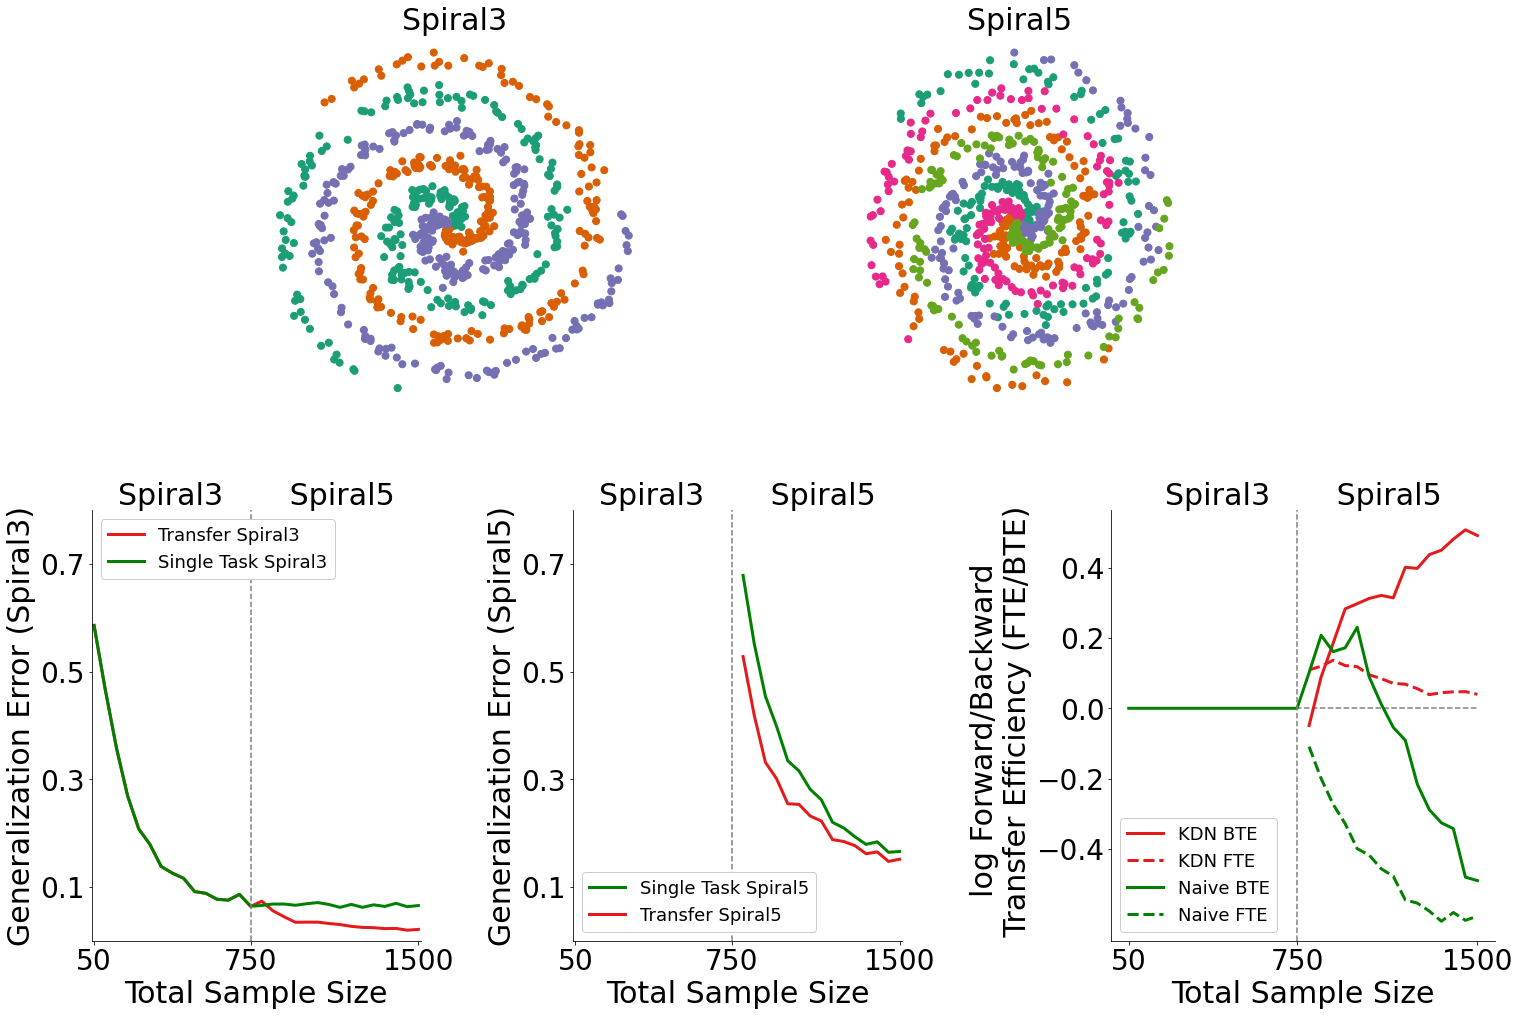

In [ ]:
n_data = 750

s3, s3_labels = generate_spirals(n_data, n_class = 3)
s5, s5_labels = generate_spirals(n_data, n_class = 5)

plot_error_and_eff(n_t1, n_t2,
                   mean_error, mean_te,
                   "Spiral3", "Spiral5",
                   s3, s3_labels,
                   s5, s5_labels)

Text(0.5, 1.0, 'Spiral5')

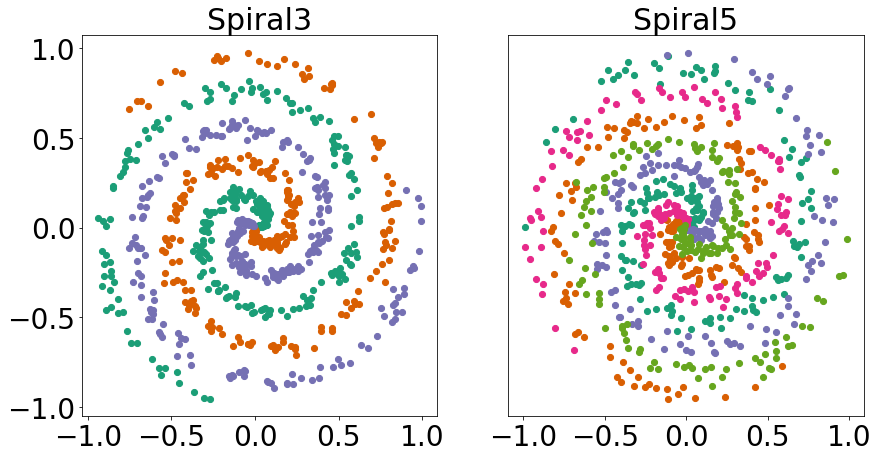

In [ ]:
fig1, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0] = plot_2dsim(s3, s3_labels, palette="Dark2", s=150, ax=ax[0])
ax[1] = plot_2dsim(s5, s5_labels, palette="Dark2", s=150, ax=ax[1])
ax[0].tick_params(labelsize=28)
ax[1].tick_params(labelsize=28)
ax[0].set_xticks([-1, -0.5, 0, 0.5, 1])
ax[0].set_yticks([-1, -0.5, 0, 0.5, 1])
ax[1].set_xticks([-1, -0.5, 0, 0.5, 1])
ax[1].set_yticks([])
ax[0].set_title("Spiral3", fontsize=30)
ax[1].set_title("Spiral5", fontsize=30)
